# Gaussian mixture model, marginalized

In [1]:
import arviz
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pystan
import pandas as pd
from scipy.stats import uniform, norm
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import collections
from scipy.stats import multivariate_normal

In [2]:

# import some data to play with
iris = datasets.load_iris()

X = iris.data
Y = iris.target

#y = iris.target
X.shape
X = ((X - X.mean(0))/X.std(0))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


In [3]:
model = """
data {
 matrix[4,4] EYE;
 int N;
 matrix[N,4] x;
 vector[4] ones;
 vector[4] zeros;
 real df;
}

parameters {
  cov_matrix[4] lambda1; 
  cov_matrix[4] lambda2;   
  cov_matrix[4] lambda3;
  vector[4] mu1;
  vector[4] mu2;
  vector[4] mu3;
  simplex[3] y[N];
  simplex[3] pi;

}

model {
 pi[1] ~ normal(0.33,0.01);
 pi[2] ~ normal(0.33,0.01);

 mu1 ~ multi_normal(zeros, EYE);
 mu2 ~ multi_normal(zeros, EYE);
 mu3 ~ multi_normal(zeros, EYE);
 
 lambda1 ~ inv_wishart(df, 0.5*EYE);
 lambda2 ~ inv_wishart(df, 0.5*EYE);
 lambda3 ~ inv_wishart(df, 0.5*EYE);

 for (n in 1:N) 
     target += log_sum_exp([ log(pi[1]) + log(y[n,1])+multi_normal_lpdf(x[n] | mu1, lambda1),
                             log(pi[2]) + log(y[n,2])+multi_normal_lpdf(x[n] | mu2, lambda2),
                             log(pi[3]) + log(y[n,3])+multi_normal_lpdf(x[n] | mu3, lambda3)]);
 
      
   }                      
"""

In [4]:
gmm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ada40cbd750dfdb31fb0bfd5afac3050 NOW.


In [5]:
eye = np.eye(4) 


In [6]:
fit = gmm.sampling(data={'x':np.array(X_train), 'df':4., 'EYE':eye,'N':135,'zeros':[0,0,0,0],'ones':[1,1,1,1]}, iter=800, chains=1,verbose=True)

In [7]:
print(fit)

Inference for Stan model: anon_model_ada40cbd750dfdb31fb0bfd5afac3050.
1 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=400.

               mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda1[1,1]   0.57  7.7e-3   0.12    0.37   0.49   0.56   0.64    0.9    250   1.01
lambda1[2,1]   0.27  7.1e-3    0.1    0.08    0.2   0.25   0.32   0.51    199   1.01
lambda1[3,1]    0.2  3.0e-3   0.05    0.12   0.16   0.19   0.22   0.31    241   1.02
lambda1[4,1]   0.08  3.1e-3   0.05   -0.01   0.05   0.08   0.11   0.18    243    1.0
lambda1[1,2]   0.27  7.1e-3    0.1    0.08    0.2   0.25   0.32   0.51    199   1.01
lambda1[2,2]   0.56  9.1e-3   0.13    0.35   0.46   0.55   0.64   0.84    211   1.01
lambda1[3,2]   0.11  2.6e-3   0.04    0.05   0.09   0.11   0.13   0.21    244    1.0
lambda1[4,2]   0.18  3.1e-3   0.06    0.08   0.14   0.17   0.21   0.31    333    1.0
lambda1[1,3]    0.2  3.0e-3   0.05    0.12   0.16 

INFO:numba.transforms:finding looplift candidates
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plo

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D92A8DAB08>,
      dtype=object)

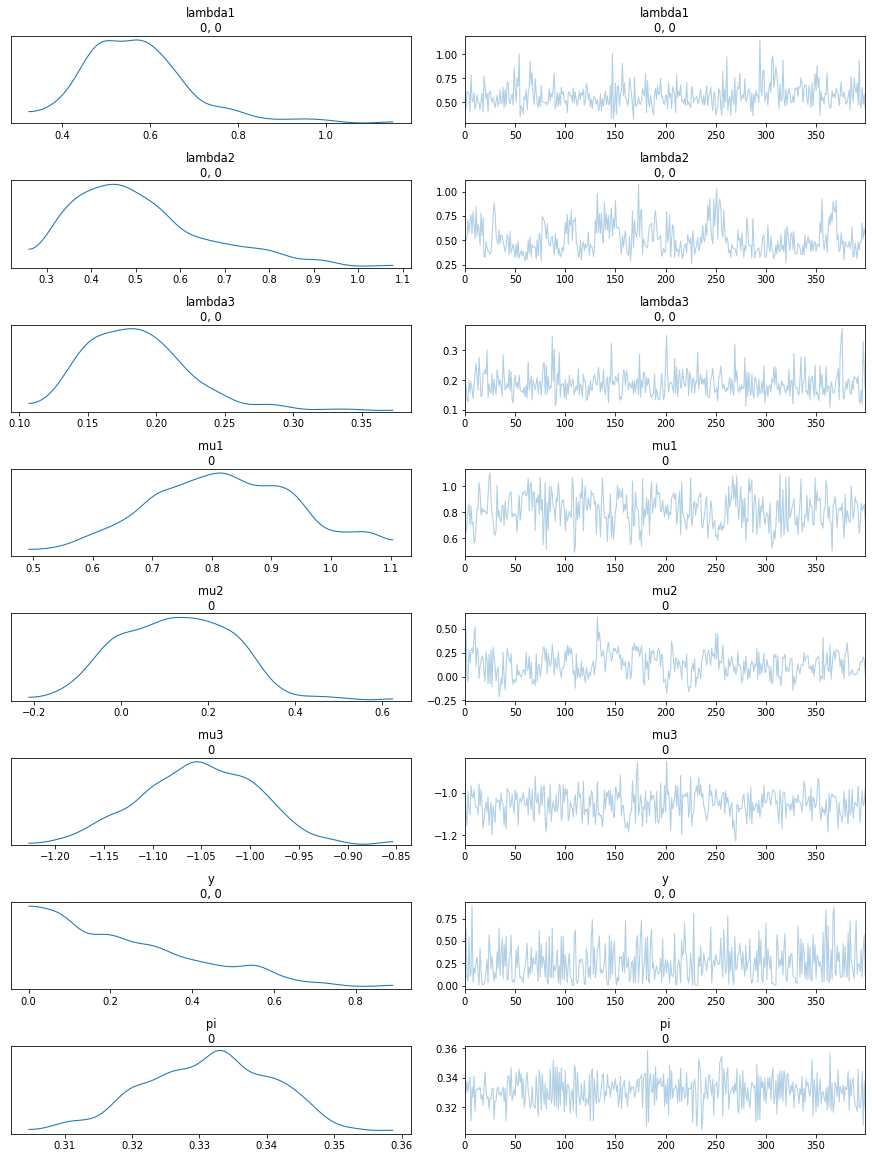

In [8]:
arviz.plot_trace(fit)

In [9]:
# summary
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'],
                  columns=summary_dict['summary_colnames'],
                  index=summary_dict['summary_rownames'])
df

mean   se_mean         sd         2.5%          25%  \
lambda1[1,1]    0.572828  0.007726   0.122250     0.371066     0.485952   
lambda1[2,1]    0.266872  0.007141   0.100821     0.084424     0.203915   
lambda1[3,1]    0.195851  0.002997   0.046536     0.122975     0.164090   
lambda1[4,1]    0.078650  0.003121   0.048679    -0.013989     0.050762   
lambda1[1,2]    0.266872  0.007141   0.100821     0.084424     0.203915   
...                  ...       ...        ...          ...          ...   
y[135,3]        0.247098  0.009458   0.193453     0.009136     0.093837   
pi[1]           0.331419  0.000406   0.009776     0.310829     0.324677   
pi[2]           0.330441  0.000364   0.010189     0.309970     0.324036   
pi[3]           0.338140  0.000472   0.013508     0.308948     0.328982   
lp__         -991.072874  1.305144  14.705416 -1023.849626 -1000.142202   

                     50%         75%       97.5%       n_eff      Rhat  
lambda1[1,1]    0.562740    0.636238    0.897665  250.400255  1.013452  
lambda1[2,1]    0.253859    0.315662    0.510216  199.329196  1.009105  
lambda1[3,1]    0.190840    0.218821    0.307735  241.038513  1.018032  
lambda1[4,1]    0.076147    0.106683    0.181452  243.253463  1.004225  
lambda1[1,2]    0.253859    0.315662    0.510216  199.329196  1.009105  
...                  ...         ...         ...         ...       ...  
y[135,3]        0.192647    0.369139    0.693472  418.374444  0.999064  
pi[1]           0.332219    0.338766    0.348842  581.238547  0.997502  
pi[2]           0.329834    0.337002    0.349977  784.773095  0.997893  
pi[3]           0.338012    0.347160    0.366454  820.540597  0.997775  
lp__         -990.093419 -981.129399 -963.699109  126.951404  1.024406  

[469 rows x 10 columns]

## Sample from fited dtribution

In [10]:
mu1 = fit['mu1'].mean(axis=0)
mu2 = fit['mu2'].mean(axis=0)
mu3 = fit['mu3'].mean(axis=0)
cov1 = fit['lambda1'].mean(axis=0)
cov2 = fit['lambda2'].mean(axis=0)
cov3 = fit['lambda3'].mean(axis=0)
pi = fit['pi'].mean(axis=0)

In [11]:
samples = []
for k in range(1000):
    index = np.random.choice(np.arange(0, 3), p=pi)
    if index ==0:
        sample = np.random.multivariate_normal(mu1, cov1)
    if index ==1:
        sample = np.random.multivariate_normal(mu2, cov2)
    if index ==2:
        sample = np.random.multivariate_normal(mu3, cov3)
    samples.append(sample)

In [12]:
samples_mean = np.array(samples).mean(axis=0)
samples_max = np.array(samples).max(axis=0)
samples_min = np.array(samples).min(axis=0)
samples = np.array(samples)
samples[:,0].shape

(1000,)

In [13]:
def test_quatitive(ax, data, gt_data, quant, tail="left"):
    quant_data = [quant(data[i]) for i in range(len(data))]
    VALUE = quant(gt_data)
    ax.hist(quant_data)
    ax.axvline(x=VALUE, color='red')
    # compute p-values and display them as subplot titles
    if tail == "left":
        ax.set_title("p-value = {:.2f}".format(sum(quant_data < VALUE)/len(quant_data)))
    if tail == "right":
        ax.set_title("p-value = {:.2f}".format(sum(quant_data > VALUE)/len(quant_data)))
        
def q95(data):
    return np.quantile(data,0.10)

def q5(data):
    return np.quantile(data,0.10)


# Model Checking

## Mean

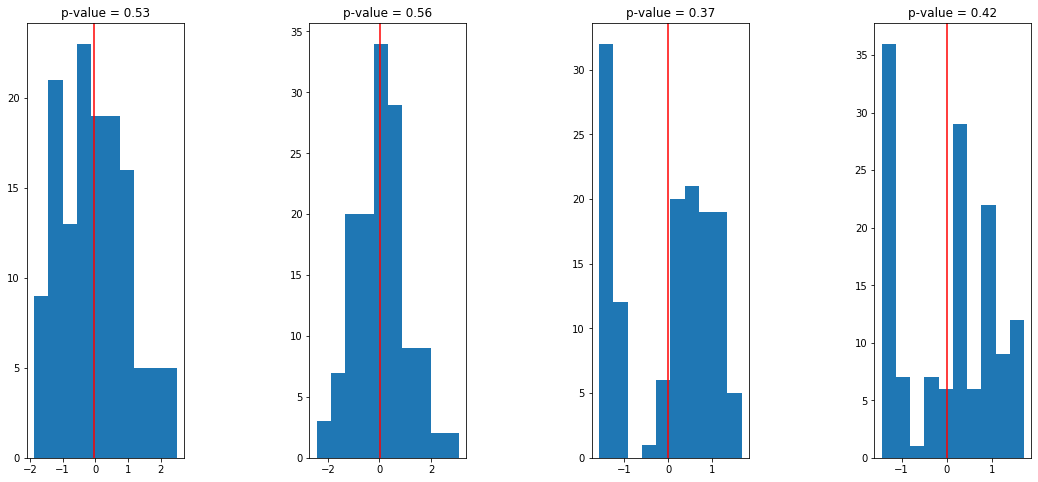

In [14]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], np.mean)
test_quatitive(axs[1], X_train[:,1], samples[:,1], np.mean)
test_quatitive(axs[2], X_train[:,2], samples[:,2], np.mean)
test_quatitive(axs[3], X_train[:,3], samples[:,3], np.mean)

## 95% quantile

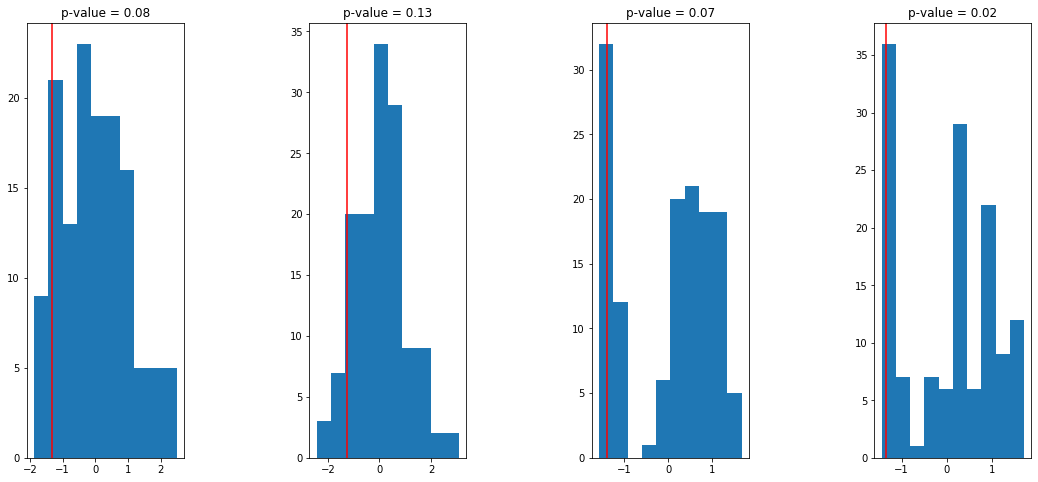

In [15]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], q95);
test_quatitive(axs[1], X_train[:,1], samples[:,1], q95);
test_quatitive(axs[2], X_train[:,2], samples[:,2], q95);
test_quatitive(axs[3], X_train[:,3], samples[:,3], q95);

## 5% quantile

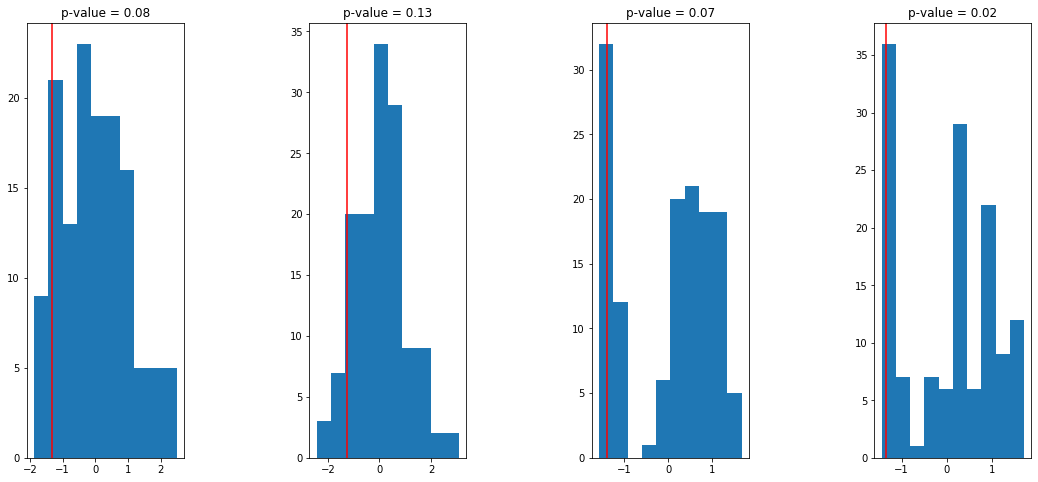

In [16]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], q5)
test_quatitive(axs[1], X_train[:,1], samples[:,1], q5)
test_quatitive(axs[2], X_train[:,2], samples[:,2], q5)
test_quatitive(axs[3], X_train[:,3], samples[:,3], q5)

# Inference

## Finding gaussian label

In [17]:
label_to_gaussian = collections.defaultdict(lambda : [0,0,0])
for sample, label in zip(X_train,y_train):
    prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
    prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
    prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
    prediction = np.argmax([prediction0, prediction1, prediction2])
    label_to_gaussian[label][prediction]+=1
print(label_to_gaussian)

defaultdict(<function <lambda> at 0x000001D92BB7FC18>, {1: [2, 42, 0], 2: [46, 1, 0], 0: [0, 0, 44]})


In [18]:
gaussian_to_label_mapping = {0:np.argmax(label_to_gaussian[0]),1:np.argmax(label_to_gaussian[1]),2:np.argmax(label_to_gaussian[2])}
correct = 0
for sample,label in zip(X_test, y_test):
    prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
    prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
    prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
    #print([prediction0,prediction1,prediction2])
    prediction = np.argmax([prediction0,prediction1,prediction2])
    prediction = gaussian_to_label_mapping[prediction]
    if prediction == label:
        correct += 1
correct/len(X_test)

0.9333333333333333

## Sensativity analysis

In [20]:
fits1 = {}
for a in range(4, 10):
    fit12 = gmm.sampling(data={'x':np.array(X_train), 'df':a, 'EYE':eye,'N':135,'zeros':[0,0,0,0],'ones':[1,1,1,1]}, iter=800, chains=1,verbose=True)
    fits1[a] = fit12
    

In [ ]:
res = {}
for a in range(4, 10):
    mu1 = fits1[a]['mu1'].mean(axis=0)
    mu2 = fits1[a]['mu2'].mean(axis=0)
    mu3 = fits1[a]['mu3'].mean(axis=0)
    cov1 = fits1[a]['lambda1'].mean(axis=0)
    cov2 = fits1[a]['lambda2'].mean(axis=0)
    cov3 = fits1[a]['lambda3'].mean(axis=0)
    pi = fits1[a]['pi'].mean(axis=0)
    label_to_gaussian = collections.defaultdict(lambda : [0,0,0])
    for sample, label in zip(X_train,y_train):
        prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
        prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
        prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
        prediction = np.argmax([prediction0, prediction1, prediction2])
        label_to_gaussian[label][prediction]+=1
    print(label_to_gaussian)
    gaussian_to_label_mapping = {0:np.argmax(label_to_gaussian[0]),1:np.argmax(label_to_gaussian[1]),2:np.argmax(label_to_gaussian[2])}
    correct = 0
    for sample,label in zip(X_test, y_test):
        prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
        prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
        prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
        prediction = np.argmax([prediction0,prediction1,prediction2])
        prediction = gaussian_to_label_mapping[prediction]
        if prediction == label:
            correct += 1
    res[a] = correct/len(X_test)
    
print(res)

# Model improvment

In [21]:
model2 = """
data {
 matrix[4,4] EYE;
 int N;
 matrix[N,4] x;
 vector[4] ones;
 vector[4] zeros;
  real df;

}

parameters {
  cov_matrix[4] lambda1; 
  cov_matrix[4] lambda2;   
  cov_matrix[4] lambda3;
  vector[4] mu1;
  vector[4] mu2;
  vector[4] mu3;
  simplex[3] pi;
  vector<lower=0>[4] inv_prior;
    real param;
}

model {
 pi[1] ~ normal(0.333,0.1);
 pi[2] ~ normal(0.333,0.1);

 mu1 ~ multi_normal(zeros, param*EYE);
 mu2 ~ multi_normal(zeros, param*EYE);
 mu3 ~ multi_normal(zeros, param*EYE);
 
 inv_prior ~ multi_normal(ones, 0.5*EYE);
 
 lambda1 ~ inv_wishart(df, diag_matrix(inv_prior));
 lambda2 ~ inv_wishart(df, diag_matrix(inv_prior));
 lambda3 ~ inv_wishart(df, diag_matrix(inv_prior));

 for (n in 1:N) 
     target += log_sum_exp([ log(pi[1]) + multi_normal_lpdf(x[n] | mu1, lambda1),
                             log(pi[2]) + multi_normal_lpdf(x[n] | mu2, lambda2),
                             log(pi[3]) + multi_normal_lpdf(x[n] | mu3, lambda3)]);
 
   }                      
# """
 

In [22]:
gmm2 = pystan.StanModel(model_code=model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fa860465974be1f6dbf5aa4e7b67d7f0 NOW.


In [23]:
fit2 = gmm2.sampling(data={'x':np.array(X_train), 'df':4, 'EYE':eye,'N':135,'zeros':[0,0,0,0],'ones':[1,1,1,1]}, iter=800, chains=1,verbose=True)

In [24]:
print(fit2)

Inference for Stan model: anon_model_fa860465974be1f6dbf5aa4e7b67d7f0.
1 chains, each with iter=800; warmup=400; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=400.

               mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda1[1,1]   0.49    0.01   0.15     0.3   0.39   0.46   0.55   0.89    151    1.0
lambda1[2,1]   0.34  6.8e-3   0.12    0.16   0.25   0.32    0.4   0.63    301    1.0
lambda1[3,1]   0.16  7.5e-3   0.08    0.08   0.11   0.14   0.18   0.38    108    1.0
lambda1[4,1]   0.11  5.4e-3   0.06    0.05   0.08    0.1   0.13   0.27    127    1.0
lambda1[1,2]   0.34  6.8e-3   0.12    0.16   0.25   0.32    0.4   0.63    301    1.0
lambda1[2,2]   0.61  7.7e-3   0.15    0.38    0.5    0.6   0.69   0.98    394    1.0
lambda1[3,2]   0.15  3.7e-3   0.06    0.08   0.11   0.14   0.18   0.32    247    1.0
lambda1[4,2]   0.16  3.0e-3   0.05    0.09   0.12   0.15   0.19   0.31    316    1.0
lambda1[1,3]   0.16  7.5e-3   0.08    0.08   0.11 

C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\sharon\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D92ECC0D88>,
      dtype=object)

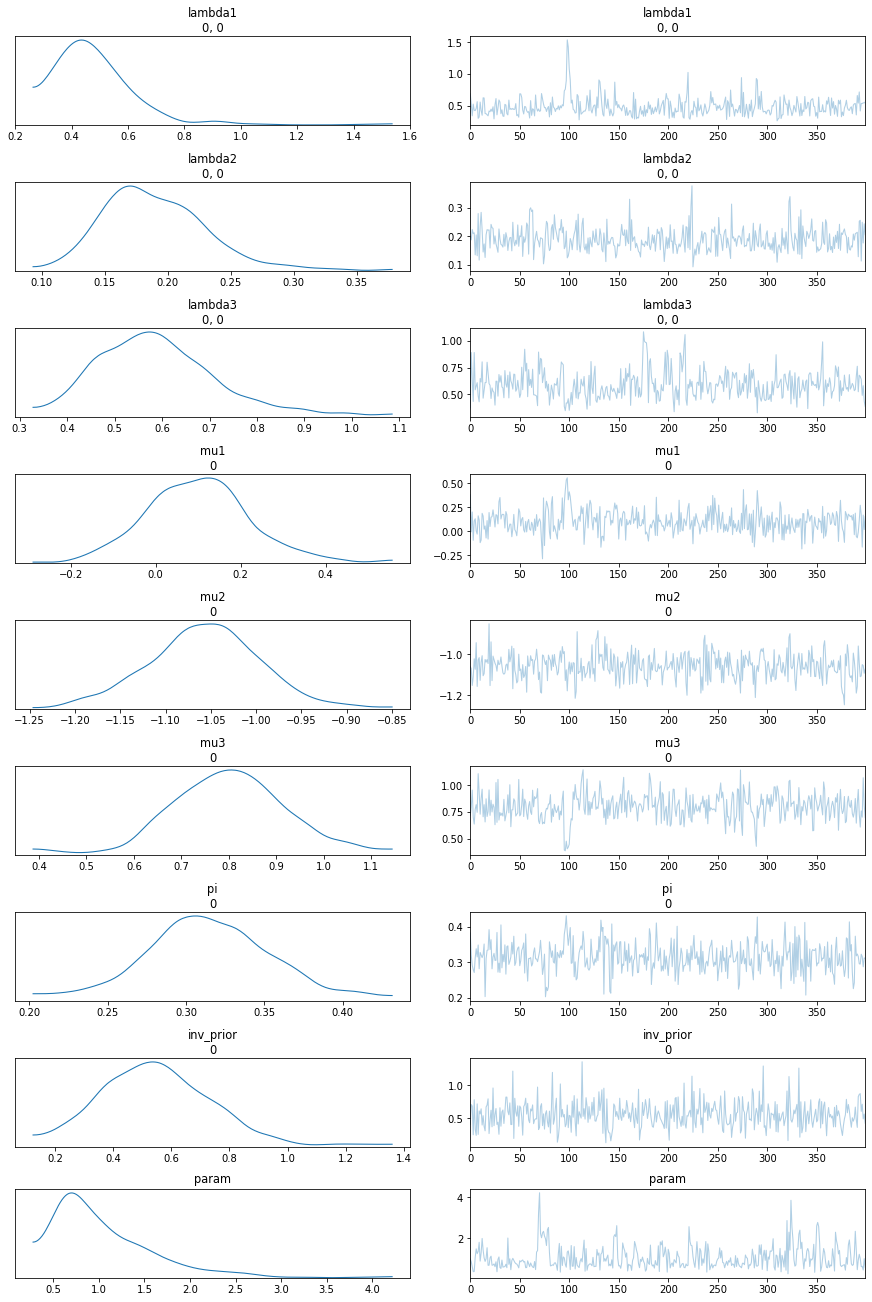

In [25]:
arviz.plot_trace(fit2)

In [26]:
# summary
summary_dict2 = fit2.summary()
df2 = pd.DataFrame(summary_dict2['summary'],
                  columns=summary_dict2['summary_colnames'],
                  index=summary_dict2['summary_rownames'])
df2

mean   se_mean        sd        2.5%         25%  \
lambda1[1,1]    0.485135  0.011896  0.146073    0.303190    0.394243   
lambda1[2,1]    0.337500  0.006774  0.117463    0.156438    0.250975   
lambda1[3,1]    0.155977  0.007538  0.078470    0.081876    0.112979   
lambda1[4,1]    0.114202  0.005360  0.060372    0.047026    0.078889   
lambda1[1,2]    0.337500  0.006774  0.117463    0.156438    0.250975   
...                  ...       ...       ...         ...         ...   
inv_prior[2]    1.137411  0.018290  0.383692    0.483951    0.838390   
inv_prior[3]    0.065079  0.001236  0.026263    0.024208    0.046434   
inv_prior[4]    0.117265  0.002174  0.048159    0.041416    0.080211   
param           1.059493  0.050770  0.559638    0.391683    0.667254   
lp__         -274.179949  0.440020  5.420033 -285.700947 -277.645461   

                     50%         75%       97.5%       n_eff      Rhat  
lambda1[1,1]    0.459111    0.545114    0.888634  150.768935  0.998395  
lambda1[2,1]    0.318252    0.401046    0.625303  300.720010  0.997507  
lambda1[3,1]    0.138019    0.176611    0.382530  108.362388  1.000336  
lambda1[4,1]    0.101337    0.130940    0.270265  126.848305  1.002927  
lambda1[1,2]    0.318252    0.401046    0.625303  300.720010  0.997507  
...                  ...         ...         ...         ...       ...  
inv_prior[2]    1.097948    1.358151    1.996109  440.074466  1.002219  
inv_prior[3]    0.062979    0.078480    0.128369  451.784266  0.997535  
inv_prior[4]    0.111573    0.145759    0.223957  490.644702  1.002764  
param           0.899558    1.356385    2.543987  121.505795  0.998267  
lp__         -273.626981 -270.705817 -264.163214  151.725890  1.000015  

[69 rows x 10 columns]

## Sample from distribution

In [27]:
mu1 = fit2['mu1'].mean(axis=0)
mu2 = fit2['mu2'].mean(axis=0)
mu3 = fit2['mu3'].mean(axis=0)

cov1 = fit2['lambda1'].mean(axis=0)
cov2 = fit2['lambda2'].mean(axis=0)
cov3 = fit2['lambda3'].mean(axis=0)

pi = fit2['pi'].mean(axis=0)

In [28]:
samples = []
for k in range(1000):
    index = np.random.choice(np.arange(0, 3), p=pi)
    if index == 0:
        sample = np.random.multivariate_normal(mu1, cov1)
    if index == 1:
        sample = np.random.multivariate_normal(mu2, cov2)
    if index == 2:
        sample = np.random.multivariate_normal(mu3, cov3)
    samples.append(sample)

In [29]:
samples_mean = np.array(samples).mean(axis=0)
samples_max = np.array(samples).max(axis=0)
samples_min = np.array(samples).min(axis=0)
samples = np.array(samples)

## Model checking

### sensetivity analysis

In [ ]:
fits2 = {}
for a in range(4, 10):
    fit22 = gmm2.sampling(data={'x':np.array(X_train), 'df':a, 'EYE':eye,'N':135,'zeros':[0,0,0,0],'ones':[1,1,1,1]}, iter=800, chains=1,verbose=True)
    fits2[a] = fit22
    

In [ ]:
res = {}
for a in range(4, 10):
    mu1 = fits2[a]['mu1'].mean(axis=0)
    mu2 = fits2[a]['mu2'].mean(axis=0)
    mu3 = fits2[a]['mu3'].mean(axis=0)
    cov1 = fits2[a]['lambda1'].mean(axis=0)
    cov2 = fits2[a]['lambda2'].mean(axis=0)
    cov3 = fits2[a]['lambda3'].mean(axis=0)
    pi = fits2[a]['pi'].mean(axis=0)
    label_to_gaussian = collections.defaultdict(lambda : [0,0,0])
    for sample, label in zip(X_train,y_train):
        prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
        prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
        prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
        prediction = np.argmax([prediction0, prediction1, prediction2])
        label_to_gaussian[label][prediction]+=1
    print(label_to_gaussian)
    gaussian_to_label_mapping = {0:np.argmax(label_to_gaussian[0]),1:np.argmax(label_to_gaussian[1]),2:np.argmax(label_to_gaussian[2])}
    correct = 0
    for sample,label in zip(X_test, y_test):
        prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
        prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
        prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
        prediction = np.argmax([prediction0,prediction1,prediction2])
        prediction = gaussian_to_label_mapping[prediction]
        if prediction == label:
            correct += 1
    res[a] = correct/len(X_test)
    
print(res)

### Mean

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], np.mean)
test_quatitive(axs[1], X_train[:,1], samples[:,1], np.mean)
test_quatitive(axs[2], X_train[:,2], samples[:,2], np.mean)
test_quatitive(axs[3], X_train[:,3], samples[:,3], np.mean)

### 95% quantile

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], q95);
test_quatitive(axs[1], X_train[:,1], samples[:,1], q95);
test_quatitive(axs[2], X_train[:,2], samples[:,2], q95);
test_quatitive(axs[3], X_train[:,3], samples[:,3], q95);

### 5% quantile

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(18, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.8)
axs = axs.ravel()
test_quatitive(axs[0], X_train[:,0], samples[:,0], q5)
test_quatitive(axs[1], X_train[:,1], samples[:,1], q5)
test_quatitive(axs[2], X_train[:,2], samples[:,2], q5)
test_quatitive(axs[3], X_train[:,3], samples[:,3], q5)

## Inference

In [ ]:
label_to_gaussian = collections.defaultdict(lambda : [0,0,0])

for sample, label in zip(X_train,y_train):
    prediction0 = multivariate_normal.pdf(sample, mu1, cov1)
    prediction1 = multivariate_normal.pdf(sample, mu2, cov2)
    prediction2 = multivariate_normal.pdf(sample, mu3, cov3)
    prediction = np.argmax([prediction0, prediction1, prediction2])
    label_to_gaussian[label][prediction] += 1

print(label_to_gaussian)

In [ ]:
gaussian_to_label_mapping = {0:np.argmax(label_to_gaussian[0]), 1:np.argmax(label_to_gaussian[1]), 2:np.argmax(label_to_gaussian[2])}

In [ ]:
gaussian_to_label_mapping

In [ ]:
correct = 0

for sample, label in zip(X_test, y_test):
    prediction0 = multivariate_normal.pdf(sample,mu1,cov1)
    prediction1 = multivariate_normal.pdf(sample,mu2,cov2)
    prediction2 = multivariate_normal.pdf(sample,mu3,cov3)
    #print([prediction0, prediction1, prediction2])
    prediction = np.argmax([prediction0, prediction1, prediction2])
    prediction = gaussian_to_label_mapping[prediction]
    if prediction == label:
        correct += 1
        
correct/len(X_test)